# Ornstein-uhlenbeck model fitting test environement

With the idea of exploring how the theory can be applied to real historic data a proof-of-concept is shown here where limited historic data is used:
1) To create a stationary portfolio
2) To fit Ornstein-uhlenbeck model to the data

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

## 0) Data loading

In [39]:
price_data  = pd.read_csv('yfinance_bel20_data_1h.csv').set_index('Datetime')
price_data = price_data.iloc[100:].dropna(axis=0)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

#pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [ ]:
price_data  = pd.read_csv('futures_data_6h.csv').set_index('close_time')
price_data = price_data.iloc[2000:].dropna(axis=1)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns#[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

FileNotFoundError: [Errno 2] No such file or directory: 'futures_data_6h.csv'

## 1) PCA factor model

In [3]:
def estimate_coefficients_LR(data, LOOKBACK_PERIOD):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Linear regression method'''
    #fitting the model
    X = data[:-1].reshape(-1,1)
    y = data[1:]
    model2 = LinearRegression().fit(X,y)
    a = model2.intercept_
    b = model2.coef_
    pred = model2.predict(X)
    score = model2.score(X,y)
    zeta = y - pred
    # OU parameters 
    #b = 1e-6 if b < 0 else b
    kappa = -np.log(b) * LOOKBACK_PERIOD
    m = a/(1-b)
    sigma = np.sqrt(np.var(data)*2*kappa)
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa[0], m[0], sigma[0], sigma_eq[0], score

In [4]:
import scipy.optimize as so
def compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)
    m_i, kappa, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * np.exp(-kappa * dt) - m_i * (1 - np.exp(-kappa * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-np.log(2 * np.pi) / 2) + (-np.log(np.sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood

def estimate_coefficients_MLE(X, dt, tol=1e-14):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # m_i ∈ ℝ, kappa > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    m_init = np.mean(X)
    initial_guess = (m_init, 0, 1)  # initial guesses for m_i, kappa, sigma
    result = so.minimize(compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds, tol=tol)
    m, kappa, sigma = result.x 
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa, m, sigma, sigma_eq, np.exp(result.fun)

In [8]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 100, loadings_window_size:int=50, amount_of_factors:int=3):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [296]:
def pca_limited(returns:pd.DataFrame, rebalance_speed=10, res_cov_window_size:int = 250, loadings_window_size:int=45, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    begin = min(rebalance_speed, res_cov_window_size)
    epochs = int(len(returns) // rebalance_speed)

    for epoch in range(1,epochs-1):
        # only use the columns with no missing values
        if epoch*rebalance_speed- res_cov_window_size < 0:
            continue
        idxsSelected = ~np.any(np.isnan(returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed,idxsSelected]
        R_oos           = returns[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos.T
        residuals_output[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected]                = residuals.T
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [297]:
test                      = pct_ret
PCA, pca_portfolio        = pca_limited(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [298]:
(np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()

0.004405102476848432

Text(0.5, 1.0, 'Residuals created for selected BEL20 stocks, rebalanced every timestep')

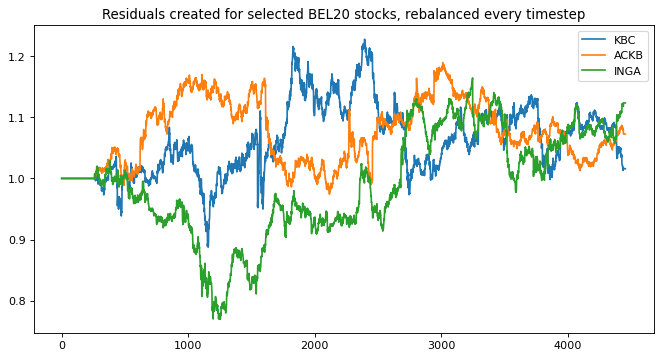

In [299]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((residuals[['KBC.BR','ACKB.BR','INGA.AS']].values+1).cumprod(axis=0))
plt.legend(['KBC','ACKB','INGA'])
plt.title('Residuals created for selected BEL20 stocks, rebalanced every timestep')

Text(0.5, 1.0, 'Correlation matrix of the residuals')

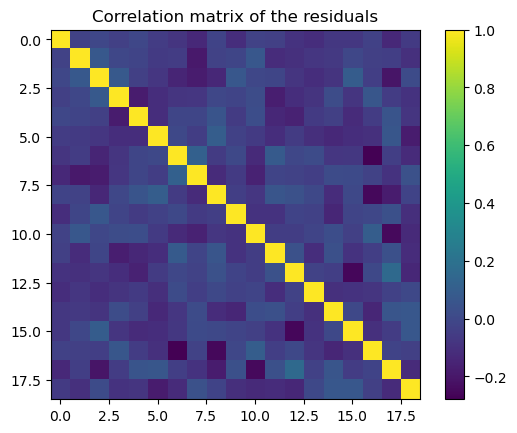

In [300]:
ax1 = plt.imshow(residuals.corr(),)
plt.colorbar(ax1)
plt.title('Correlation matrix of the residuals')

## 2) PCA factor model rebalancing times

In [11]:
rebalance_times = list(range(1,60))
result_cost = list()
result_kappa = list()
result_r2 = list()

for time in rebalance_times:
    print(time)
    PCA, pca_portfolio        = pca_limited(pct_ret,rebalance_speed=time) 
    avg_change= (np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()
    T, N = PCA.shape
    kappas = list()
    R2s    = list()
    for idx in range(N):
        kappa, _,_,_,R2 = estimate_coefficients_LR((PCA[:,idx]+1).cumprod(),T)
        kappas.append(kappa)
        R2s.append(R2)
    result_kappa.append(sum(kappas)/N)
    result_r2.append(sum(R2s)/N)
    result_cost.append(avg_change)    

1


KeyboardInterrupt: 

In [18]:
LR.intercept_, LR.coef_
LR.estimate(np.array(rebalance_times).reshape(-1,1))

AttributeError: 'LinearRegression' object has no attribute 'estimate'

Text(0, 0.5, '$avg. \\theta$ from OU-fit')

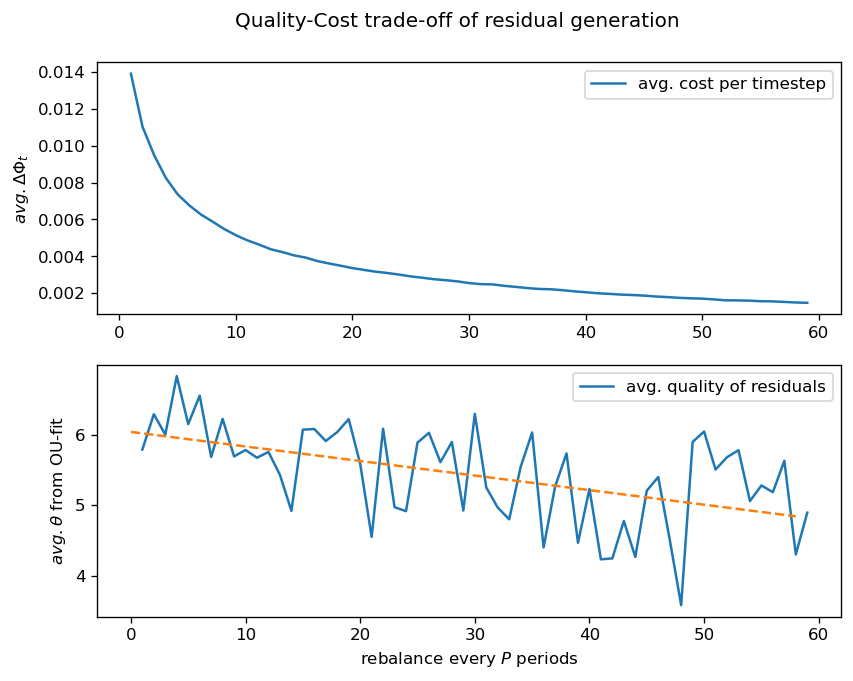

In [26]:
fig, ax = plt.subplots(2,1,figsize=(8,6),dpi=120)
#plt.tight_layout()
plt.suptitle('Quality-Cost trade-off of residual generation',y=0.95)
# plot a sample path of the wealth
ax[0].plot(rebalance_times, result_cost)
ax[0].legend([r'avg. cost per timestep'])
ax[0].set_ylabel(r'$avg. \Delta\Phi_t$')
ax[1].set_xlabel(r'rebalance every $P$ periods')
#ax[0].set_xlabel('Time')
ax[1].plot(rebalance_times,result_kappa)
LR = LinearRegression(fit_intercept=True, n_jobs=-1).fit(np.array(rebalance_times).reshape(-1,1),result_kappa)
ax[1].plot(LR.predict(np.array(rebalance_times).reshape(-1,1)),'--')
ax[1].legend([r'avg. quality of residuals'])
ax[1].set_ylabel(r'$avg. \theta$ from OU-fit')
#ax[2].plot(rebalance_times,result_r2)
#ax[2].legend([r'$R^2$ of OU fit'])


In [14]:
def preprocess_ou(data:np.array, lookback:int=40):
    #print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             print(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             print(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    #print("Finish OU preprocess")
    return windows, idxs_selected

In [15]:
plt.plot(np.flip(eigenValues / eigenValues.sum()))
plt.title('SCREE plot of eigenvalues')

NameError: name 'eigenValues' is not defined

## 3) RP-PCA factor model

In [38]:
is_returns = pct_ret

In [20]:
#finding factors using RP-PCA
gamma = 20
T,N = is_returns.shape
res_mean = np.mean(is_returns,axis=0,keepdims=True)
RPPCA_matrix = 1/T * is_returns.T @ is_returns + gamma * res_mean @ res_mean.T
eigenValues, eigenVectors = np.linalg.eigh(RPPCA_matrix)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
R           = is_returns
wtR         = is_returns @ w                  # R * w 
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ w.T)

is_residuals   = phi @ R.T
oos_residuals  = phi @ oos_returns.T

NameError: name 'is_returns' is not defined

## 4) Sparse PCA factor model

In [217]:
amount_of_factors = 3
sparsity = 0.4 # the amount of smallest entries that will be set to 0

In [218]:
is_returns = in_sample.dropna().values
oos_returns = out_sample.dropna().values

In [219]:
def set_sparsity(array, spar):
    rows, cols = array.shape
    n = int(np.floor(spar*rows))
    out_array = array.copy()
    for col in range(cols):
        out_array[np.argsort(np.abs(array[:,col].flatten()))[:n],col] = 0
        out_array[:,col] = out_array[:,col] / np.linalg.norm(out_array[:,col],2)
    return out_array

In [220]:
from sklearn import linear_model
#finding factors using sparse pca
T,N = is_returns.shape
res_mean = np.mean(is_returns,axis=0,keepdims=True)
PCA_matrix = 1/(T*N) * is_returns.T @ is_returns
eigenValues, eigenVectors = np.linalg.eigh(PCA_matrix)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
#w           = eigenVectors[:,-amount_of_factors:].real                      # w
sparse_w    = set_sparsity(w, sparsity)
R           = is_returns
wtR         = is_returns @ sparse_w                  # R * w 
regr        = LinearRegression(fit_intercept=False,n_jobs=1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ sparse_w.T)

is_residuals   = phi @ R.T
oos_residuals  = phi @ oos_returns.T

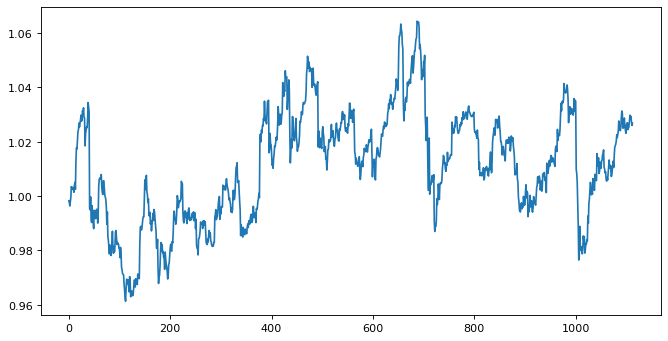

In [221]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((oos_residuals[15,:]+1).cumprod(axis=0))

In [287]:
def pca_sparse_limited(returns:pd.DataFrame, rebalance_speed=10, res_cov_window_size:int = 250, loadings_window_size:int=45, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    begin = min(rebalance_speed, res_cov_window_size)
    epochs = int(len(returns) // rebalance_speed)

    for epoch in range(1,epochs-1):
        # only use the columns with no missing values
        if epoch*rebalance_speed- res_cov_window_size < 0:
            continue
        idxsSelected = ~np.any(np.isnan(returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed,idxsSelected]
        R_oos           = returns[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        sparse_w    = set_sparsity(w, sparsity)
        R           = res_cov_window[-loadings_window_size:,:]
        
        wtR         = res_cov_window[-loadings_window_size:,:] @ sparse_w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ sparse_w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos.T
        residuals_output[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected]                = residuals.T
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [288]:
test                      = pct_ret
PCA, pca_portfolio        = pca_sparse_limited(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [289]:
(np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()

0.004856545003722146

In [291]:
(residuals.values+1).cumprod(axis=0)[-1,:]

array([1.38418372, 1.01085251, 1.24921301, 1.10239847, 1.35069971,
       0.64948539, 0.51386224, 0.97548906, 1.41586427, 0.99344852,
       1.57979834, 1.21865967, 1.10154875, 0.85157729, 0.81875768,
       1.05367305, 0.94881564, 0.80329228, 0.69175955])

Text(0.5, 1.0, 'Residuals created for selected BEL20 stocks, rebalanced every timestep')

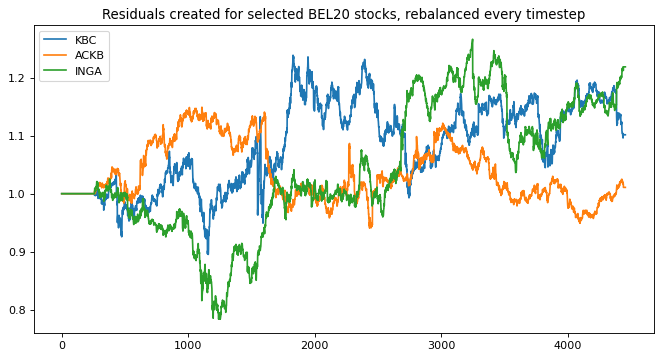

In [295]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((residuals[['KBC.BR','ACKB.BR','INGA.AS']].values+1).cumprod(axis=0))
plt.legend(['KBC','ACKB','INGA'])
plt.title('Residuals created for selected BEL20 stocks, rebalanced every timestep')

## 5) Instrumented PCA factor model

In [255]:
import numpy as np
import pandas as pd
import datetime as dt
begin =  dt.datetime(2018,1,1)
end   =  dt.datetime(2020,1,1)
end_oos = dt.datetime(2020,5,1)

data = pd.read_csv('monthly_IPCA_panel.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.date = pd.to_datetime(data.date)

data_oos = data[(data.date > end) & (data.date < end_oos)].drop(['AC', 'DPI2A','OA','OL','OP','SGA2S'],axis=1)
data_oos = data_oos.set_index(['PERMNO', 'date'])
data_oos = data_oos.dropna(axis=0)

data = data[(data.date > begin) & (data.date < end)].drop(['AC', 'DPI2A','OA','OL','OP','SGA2S'],axis=1)
data = data.set_index(['PERMNO', 'date'])
data = data.dropna(axis=0)

X = data[data.columns.difference(['TICKER', 'CUSIP', 'RET'])]
X = X.replace(['C','B'],np.nan).astype(float)
y = data['RET']
y = y.replace(['C','B'],np.nan).astype(float)

X_oos = data_oos[data_oos.columns.difference(['TICKER', 'CUSIP', 'RET'])]
X_oos = X_oos.replace(['C','B'],np.nan).astype(float)
y_oos = data_oos['RET']
y_oos = y_oos.replace(['C','B'],np.nan).astype(float)

In [481]:
from ipca import InstrumentedPCA
class IPCA:
    def __init__(self, monthly_panel:pd.DataFrame, permnos, train_window:int=48, n_factors:int=5, retrain_period:int=252) -> None:
        self.permnos      = permnos
        self.train_window = train_window
        self.retrain_period= retrain_period
        self.n_factors    = n_factors
        self.instruments  = monthly_panel[monthly_panel.columns.difference(['TICKER', 'CUSIP', 'RET'])]
        self.returns      = monthly_panel[['RET','PERMNO','date']]
        self.dates        = pd.to_datetime(monthly_panel.date.sort_values().unique())
        self.train_date   = None
        self.rebalance_date  = None
        self.residual_portf, self.idxsSelected = None, None

    def step(self, date:dt.datetime):
        # check if the model needs to be refit
        if self.train_date == None:
            self._fit_model(date=date)
            self.train_date  = date
        elif date - self.train_date > dt.timedelta(days=self.retrain_period):
            self._fit_model(date=date)
            self.train_date = date
        
        #check if new weights can be used
        if self.rebalance_date == None:
             self._calculate_weights(date=date)
        elif self._find_nearest_date(date) > self.rebalance_date:
            self._calculate_weights(date=date)
        assert self.residual_portf is not None and self.idxsSelected is not None
        return self.residual_portf, self.idxsSelected
    
    def _fit_model(self, date:dt.datetime) -> None:
        start, end = self._find_start_end(date, diff=self.train_window)
        X = self.instruments[(self.instruments.date <= end) & (self.instruments.date >= start)]
        y = self.returns[(self.returns.date <= end) & (self.returns.date >= start)]
        X = X.set_index(['PERMNO', 'date']).replace(['C','B'],np.nan).astype(float)
        y = y.set_index(['PERMNO', 'date']).replace(['C','B'],np.nan).astype(float).squeeze()
        self.regr = InstrumentedPCA(n_factors=self.n_factors, intercept=False)
        self.regr = self.regr.fit(X=X, y=y, quiet=True)
        self.Gamma, self.Factors = self.regr.get_factors(label_ind=True)
    
    def _calculate_weights(self, date:dt.datetime) -> np.ndarray:
        G   = self.Gamma.values
        C = self.instruments[self.instruments.date == self._find_nearest_date(date)]
        C = C.drop(['date'],axis=1)
        C = C.dropna(axis=0)
        selected_permnos = C.PERMNO # not sure if this is enough to ensure that the right stocks are associated with the right weights
        C = C.drop(['PERMNO'],axis=1).values.astype(float)
        psi  = np.linalg.inv(G.T @ C.T @ C @ G) @ G.T @ C.T 
        beta = C @ G
        weights = np.eye(C.shape[0]) - (beta @ psi)
        out = pd.DataFrame(index=self.permnos, columns=self.permnos).fillna(0)
        out.loc[selected_permnos, selected_permnos] = weights
        self.residual_portf =  out.values
        self.idxsSelected = np.array([company in selected_permnos.values for company in self.permnos])
        assert np.all((out.sum(axis=0).values !=0) == self.idxsSelected)
    
    def _find_start_end(self, date:dt.datetime, diff:int) -> dt.datetime:
        return self.dates[self.dates < date][-diff], self.dates[self.dates < date][-1]
    
    def _find_nearest_date(self, date:dt.datetime) -> dt.datetime:
        return self.dates[self.dates < date][-1]

In [352]:
panel = pd.read_csv('monthly_IPCA_panel.csv')
panel.drop(columns=['Unnamed: 0'], inplace=True)
panel.date = pd.to_datetime(panel.date)
panel = panel.drop(['AC', 'DPI2A','OA','OL','OP','SGA2S'],axis=1)
panel = panel.dropna(axis=0)

In [482]:
ipca_obj = IPCA(monthly_panel=panel, permnos=price_df.columns.values.astype(int), train_window=48)

In [484]:
ipca_obj.step(dt.datetime(2020,2,1))

The panel dimensions are:
n_samples: 631 , L: 32 , T: 48


[========================================================================] 100%


(array([[ 9.96106891e-01, -3.32359126e-04, -2.26599854e-03, ...,
          0.00000000e+00, -2.88218339e-03,  0.00000000e+00],
        [-3.32359126e-04,  9.96643374e-01, -1.40041868e-03, ...,
          0.00000000e+00, -3.96689840e-04,  0.00000000e+00],
        [-2.26599854e-03, -1.40041868e-03,  9.96906246e-01, ...,
          0.00000000e+00, -2.05028647e-03,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.88218339e-03, -3.96689840e-04, -2.05028647e-03, ...,
          0.00000000e+00,  9.97730982e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([ True,  True,  True, ..., False,  True, False]))

In [485]:
ipca_obj.step(dt.datetime(2020,2,1))

(array([[ 9.95407014e-01, -3.92109424e-04, -1.45439100e-03, ...,
          0.00000000e+00, -2.84229423e-03,  0.00000000e+00],
        [-3.92109424e-04,  9.94062538e-01, -3.93926190e-04, ...,
          0.00000000e+00, -7.46073827e-04,  0.00000000e+00],
        [-1.45439100e-03, -3.93926190e-04,  9.95230153e-01, ...,
          0.00000000e+00, -2.41064089e-03,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.84229423e-03, -7.46073827e-04, -2.41064089e-03, ...,
          0.00000000e+00,  9.97682602e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([ True,  True,  True, ..., False,  True, False]))

In [470]:
res_portf, idxSelected = ipca_obj.step(dt.datetime(1996,1,1))

In [478]:
sum(res_portf.sum(axis=1) != 0)

289

In [473]:
idxSelected

array([False, False, False, ..., False, False, False])

In [453]:
w1 = ipca_obj.get_weights(dt.datetime(1996,2,1))
w2 = ipca_obj.get_weights(dt.datetime(1996,5,1))

In [454]:
differences = np.abs(w1 - w2).sum(axis=1)
differences[differences != 0]

array([0.46055769, 0.74444977, 1.44499322, 1.23389229, 0.44997975,
       0.81387472, 2.67345705, 0.57929209, 1.26292748, 1.26214501,
       2.07332408, 0.42521972, 1.44281342, 1.90573058, 1.89237084,
       0.73379786, 1.95523466, 0.6155851 , 1.24614713, 0.84342722,
       0.88188111, 2.46725857, 0.64446692, 1.16920884, 2.39133664,
       2.2263524 , 1.36090828, 1.62041351, 0.81864628, 0.62169874,
       1.11067639, 0.57224402, 2.05466499, 2.1255685 , 2.01849807,
       2.95996836, 1.16604333, 0.7364672 , 2.22639749, 0.54553582,
       2.40818153, 0.5497327 , 2.5332627 , 0.88278258, 1.57243897,
       0.87471712, 2.06905408, 1.80453202, 0.80658518, 1.3049075 ,
       3.0492733 , 1.50878445, 0.67267368, 0.71437996, 0.57928859,
       1.54060289, 1.40040044, 1.09168568, 0.80611529, 0.66219762,
       1.85687883, 0.46251771, 1.70138054, 1.51920486, 0.58934982,
       0.54256993, 1.05463161, 1.88088683, 1.30462486, 0.75678065,
       1.9111581 , 0.57470683, 0.92511273, 0.69049163, 0.82499

In [413]:
w

array([[ 9.91523856e-01, -5.40423366e-03, -1.34891026e-02, ...,
        -1.01129291e-02, -2.08689122e-03, -1.58399424e-03],
       [-5.40423366e-03,  9.73194460e-01, -2.69663541e-02, ...,
        -9.18746050e-03, -7.72552636e-03,  4.66158896e-04],
       [-1.34891026e-02, -2.69663541e-02,  9.37723377e-01, ...,
        -9.63134501e-03, -2.51924629e-03,  4.16665298e-03],
       ...,
       [-1.01129291e-02, -9.18746050e-03, -9.63134501e-03, ...,
         9.45488886e-01, -4.61362413e-04,  4.61317885e-03],
       [-2.08689122e-03, -7.72552636e-03, -2.51924629e-03, ...,
        -4.61362413e-04,  9.94315967e-01, -3.58391943e-03],
       [-1.58399424e-03,  4.66158896e-04,  4.16665298e-03, ...,
         4.61317885e-03, -3.58391943e-03,  9.95510013e-01]])

In [361]:
x_test

A2ME         AT       ATO      BEME         C  \
PERMNO date                                                             
80303  2004-01-30   9.122174   5050.500  0.661291  0.243294  0.011702   
       2004-02-27   9.447698   5025.600  0.727750 -0.099259  0.010884   
       2004-03-31   9.525457   5025.600  0.727750 -0.100076  0.010884   
       2004-04-30   7.886494   5025.600  0.727750 -0.082857  0.010884   
       2004-05-28  10.240488   5232.100  0.984039  0.227823  0.057319   
...                      ...        ...       ...       ...       ...   
79145  2005-08-31   1.237208  11591.538  0.123891  0.544462  0.025711   
       2005-09-30   1.316271  11591.538  0.123891  0.579255  0.025711   
       2005-10-31   1.301646  11591.538  0.123891  0.572819  0.025711   
       2005-11-30   1.316268  11244.200  0.157498  0.652169  0.016827   
       2005-12-30   1.167911  11244.200  0.157498  0.578662  0.016827   

                         CF      CF2P       CTO       D2A       E2P  ...  \
PERMNO date                                                          ...   
80303  2004-01-30 -2.109131  0.103675  0.202178  0.011365 -0.516571  ...   
       2004-02-27  3.655303  0.094935  0.209726  0.010049 -0.337257  ...   
       2004-03-31  3.655303  0.095717  0.209726  0.010049 -0.340032  ...   
       2004-04-30  3.655303  0.079248  0.209726  0.010049 -0.281526  ...   
       2004-05-28  1.792096  0.105691  0.216815  0.010321 -0.032099  ...   
...                     ...       ...       ...       ...       ...  ...   
79145  2005-08-31  0.020145  0.010671  0.103803  0.008625  0.016569  ...   
       2005-09-30  0.020145  0.011353  0.103803  0.008625  0.017628  ...   
       2005-10-31  0.020145  0.011226  0.103803  0.008625  0.017432  ...   
       2005-11-30  0.027837  0.011826  0.133599  0.008984  0.043864  ...   
       2005-12-30  0.027837  0.010493  0.133599  0.008984  0.038920  ...   

                    RET_t_1       RNA       ROA       ROE       S2P      VOLA  \
PERMNO date                                                                     
80303  2004-01-30  0.700000 -0.080111 -0.053133 -0.690154  1.844303  0.849924   
       2004-02-27 -0.039216 -0.178071 -0.035521 -1.331849  1.981430  0.822784   
       2004-03-31 -0.008163 -0.178071 -0.035521 -1.331849  1.997738  0.618246   
       2004-04-30  0.207819 -0.178071 -0.035521 -1.331849  1.654004  0.706830   
       2004-05-28 -0.199319  0.001301 -0.003263  0.310606  2.220296  0.702640   
...                     ...       ...       ...       ...       ...       ...   
79145  2005-08-31 -0.060174  0.022048  0.013383  0.031691  0.128427  0.188514   
       2005-09-30 -0.060066  0.022048  0.013383  0.031691  0.136634  0.169400   
       2005-10-31  0.014747  0.022048  0.013383  0.031691  0.135115  0.203193   
       2005-11-30 -0.040741  0.041985  0.032326  0.073457  0.175852  0.234701   
       2005-12-30  0.106660  0.041985  0.032326  0.073457  0.156032  0.219540   

                      r12_2     r12_7      r2_1    r36_13  
PERMNO date                                                
80303  2004-01-30 -0.527559 -0.429921  0.250000 -0.145299  
       2004-02-27 -0.071038 -0.562842  0.700000 -0.333683  
       2004-03-31  0.507692 -0.187692 -0.039216 -0.453731  
       2004-04-30  0.664384 -0.315068 -0.008163 -0.749422  
       2004-05-28  0.983108 -0.189189  0.207819 -0.781927  
...                     ...       ...       ...       ...  
79145  2005-08-31  0.170944  0.283293  0.051616  1.415254  
       2005-09-30  0.042431  0.083716 -0.060174  1.594221  
       2005-10-31 -0.083262 -0.040987 -0.060066  1.374728  
       2005-11-30 -0.130785 -0.154527  0.014747  1.149446  
       2005-12-30 -0.238795 -0.153012 -0.040741  1.976048  

[9705 rows x 32 columns]

In [356]:
X

A2ME         AT       ATO      BEME         C  \
PERMNO date                                                            
76712  2018-01-31  5.429817  38834.000  0.120692  0.445470  0.061750   
       2018-02-28  5.086930  38834.000  0.120692  0.417339  0.061750   
       2018-03-29  4.611982  33112.000  0.111106  0.343336  0.049740   
       2018-04-30  4.409169  33112.000  0.111106  0.328238  0.049740   
       2018-05-31  4.095772  33112.000  0.111106  0.304907  0.049740   
...                     ...        ...       ...       ...       ...   
79145  2019-08-30  1.222665  29808.962  0.123902  0.473267  0.007884   
       2019-09-30  1.364066  29808.962  0.123902  0.528000  0.007884   
       2019-10-31  1.313069  29808.962  0.123902  0.508261  0.007884   
       2019-11-29  1.307323  29825.461  0.135544  0.524977  0.009278   
       2019-12-31  1.185436  29825.461  0.135544  0.476031  0.009278   

                         CF      CF2P       CTO       D2A       E2P  ...  \
PERMNO date                                                          ...   
76712  2018-01-31 -0.355304  0.042366  0.069346  0.007802  0.020554  ...   
       2018-02-28 -0.355304  0.039690  0.069346  0.007802  0.019256  ...   
       2018-03-29 -1.311968  0.039696  0.079820  0.008607 -0.095131  ...   
       2018-04-30 -1.311968  0.037950  0.079820  0.008607 -0.090948  ...   
       2018-05-31 -1.311968  0.035253  0.079820  0.008607 -0.084483  ...   
...                     ...       ...       ...       ...       ...  ...   
79145  2019-08-30 -0.093749  0.012781  0.094154  0.010453  0.019394  ...   
       2019-09-30 -0.093749  0.014259  0.094154  0.010453  0.021637  ...   
       2019-10-31 -0.093749  0.013726  0.094154  0.010453  0.020828  ...   
       2019-11-29 -0.095046  0.014039  0.106850  0.010739  0.038715  ...   
       2019-12-31 -0.095046  0.012730  0.106850  0.010739  0.035105  ...   

                    RET_t_1       RNA       ROA       ROE       S2P      VOLA  \
PERMNO date                                                                     
76712  2018-01-31  0.023629  0.026397  0.004031  0.048659  0.376538  0.223554   
       2018-02-28  0.079409  0.026397  0.004031  0.048659  0.352761  0.280885   
       2018-03-29 -0.059689  0.025769 -0.017588 -0.214375  0.368128  0.383853   
       2018-04-30  0.045998  0.025769 -0.017588 -0.214375  0.351940  0.305285   
       2018-05-31  0.087951  0.025769 -0.017588 -0.214375  0.326925  0.172482   
...                     ...       ...       ...       ...       ...       ...   
79145  2019-08-30 -0.040178  0.025855  0.016463  0.041958  0.115119  0.256556   
       2019-09-30 -0.103662  0.025855  0.016463  0.041958  0.128432  0.273537   
       2019-10-31  0.046318  0.025855  0.016463  0.041958  0.123631  0.265516   
       2019-11-29  0.004616  0.037906  0.029630  0.076548  0.139687  0.262596   
       2019-12-31  0.102821  0.037906  0.029630  0.076548  0.126664  0.242119   

                      r12_2     r12_7      r2_1    r36_13  
PERMNO date                                                
76712  2018-01-31 -0.075175 -0.028846 -0.004704 -0.049100  
       2018-02-28 -0.059896 -0.029514  0.023629 -0.117965  
       2018-03-29  0.033989 -0.012522  0.079409 -0.103502  
       2018-04-30 -0.038904 -0.025641 -0.059689 -0.156226  
       2018-05-31 -0.026541 -0.089897  0.045998 -0.168382  
...                     ...       ...       ...       ...  
79145  2019-08-30 -0.011176 -0.020640  0.001232  0.585712  
       2019-09-30 -0.104664 -0.088195 -0.040178  0.635490  
       2019-10-31 -0.004297  0.094433 -0.103662  0.690386  
       2019-11-29 -0.041921  0.069603  0.046318  0.293442  
       2019-12-31  0.112895  0.245117  0.004616  0.378230  

[12806 rows x 32 columns]

In [363]:
X.shape

(12806, 32)

In [364]:
x_test.shape

(9705, 32)

In [366]:
y.shape

(12806,)

In [370]:
y_test.squeeze().shape

(9705,)

In [284]:
# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=10, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 592 , L: 32 , T: 24


[========================================================================] 100%


Step 1 - Aggregate Update: 3653947.181756465
Step 2 - Aggregate Update: 1.5987960025795807
Step 3 - Aggregate Update: 1.3380118402486287
Step 4 - Aggregate Update: 0.2851273027739224
Step 5 - Aggregate Update: 0.17806620430882303
Step 6 - Aggregate Update: 0.13757405111960574
Step 7 - Aggregate Update: 0.09879418079237146
Step 8 - Aggregate Update: 0.11296829931651695
Step 9 - Aggregate Update: 1.088230825198911
Step 10 - Aggregate Update: 0.19548535088901137
Step 11 - Aggregate Update: 1.056784936697556
Step 12 - Aggregate Update: 0.09032824684416962
Step 13 - Aggregate Update: 0.08140264591877505
Step 14 - Aggregate Update: 1.0304685715497137
Step 15 - Aggregate Update: 0.07260482178777461
Step 16 - Aggregate Update: 0.09070107457411036
Step 17 - Aggregate Update: 0.10078069497634856
Step 18 - Aggregate Update: 0.10305063374183143
Step 19 - Aggregate Update: 0.09869172454449932
Step 20 - Aggregate Update: 0.0897273514676771
Step 21 - Aggregate Update: 0.0784899050523275
Step 22 - Agg

In [392]:
X_t

,PERMNO,date,A2ME,AT,ATO,BEME,C,CF,CF2P,CTO,...,RET_t_1,RNA,ROA,ROE,S2P,VOLA,r12_2,r12_7,r2_1,r36_13
23,76712,2019-12-31,2.662293,33423.000,0.118666,0.250115,0.057864,-0.368153,0.020869,0.078539,...,0.109091,0.029836,0.006318,0.065461,0.209093,0.192042,0.179115,0.092669,0.051805,0.333046
47,80303,2019-12-31,5.272545,4604.600,0.665756,0.154125,0.006689,-0.614413,0.057597,0.333471,...,0.169492,0.022156,0.000597,0.020649,1.758240,0.610986,0.048889,-0.235556,0.039648,-0.698335
71,66093,2019-12-31,2.009793,548796.000,0.120413,0.670360,0.012032,-0.028375,0.025449,0.081247,...,-0.028839,0.021956,0.006765,0.020081,0.163290,0.200931,0.348633,0.071479,0.030655,-0.265460
95,20482,2019-12-31,0.453557,68539.000,0.166939,0.210549,0.063249,0.016029,0.004990,0.117831,...,0.022007,0.027926,0.014030,0.030297,0.053443,0.193180,0.155952,0.052537,0.003107,0.927883
117,13721,2019-12-31,0.458165,59441.000,0.358081,-0.063405,0.179136,-0.242888,0.003877,0.142646,...,0.102828,0.156130,0.032970,-0.219939,0.065355,0.209637,-0.137108,-0.167914,0.064712,0.505430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12718,92157,2019-12-31,0.635102,19694.000,0.233844,0.340867,0.047070,-0.019111,0.005644,0.167564,...,0.041006,0.036919,0.019040,0.035398,0.106420,0.228487,0.183393,0.113711,-0.039493,0.110421
12741,79237,2019-12-31,8.023766,24449.000,0.038724,3.916218,0.100495,-0.073075,0.069575,0.032067,...,0.048421,-0.000988,-0.032196,-0.064716,0.257296,0.597782,-0.315562,-0.106628,0.062640,-0.370421
12761,12345,2019-12-31,0.976021,30114.000,0.406412,0.255657,0.018762,-0.085319,0.010598,0.289633,...,0.043367,0.054378,0.031022,0.090197,0.282688,0.268925,0.078644,-0.107143,0.002571,0.087783
12783,12084,2019-12-31,0.582815,21254.000,0.150659,0.257487,0.166416,0.025346,0.014177,0.106568,...,0.016714,0.014367,0.005176,0.011689,0.062110,0.305465,0.551310,0.203057,0.041789,-0.149373


In [286]:
G = Gamma.values
X_flat = X.reset_index()
X_t = X_flat[X_flat.date == X_flat.date.max()]

C = X_t.iloc[:,2:].values
selected_permnos = X_t.PERMNO

psi  = np.linalg.inv(G.T @ C.T @ C @ G) @ G.T @ C.T 
beta = C @ G

weights = np.eye(C.shape[0]) - (beta @ psi)
r_oos = price_df.loc[end:end_oos,selected_permnos.astype(str)].fillna(0)

residuals = weights @ r_oos.T

In [287]:
residuals

date,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01
0,0.007111,-0.008197,0.010011,0.005988,-0.004238,0.008098,-0.002888,0.003936,0.002672,0.002248,...,-0.018103,-0.001500,0.009368,-0.004515,0.004136,0.012301,0.017234,0.032816,-0.049420,-0.003605
1,-0.008606,0.006740,0.000339,-0.004695,-0.001626,-0.001206,0.006349,-0.006189,-0.000665,0.007105,...,0.013686,0.023507,-0.004521,-0.017738,-0.011003,-0.029084,-0.022438,-0.048596,0.025684,0.035482
2,-0.001439,0.006034,0.000803,0.006370,0.003065,-0.004317,-0.005535,-0.016600,-0.003167,-0.009926,...,0.013109,-0.019738,-0.026592,0.001051,-0.001343,0.009057,-0.003876,0.017175,-0.011401,0.000287
3,-0.004438,-0.004947,0.003829,-0.003946,0.000525,-0.002433,-0.009470,-0.008367,0.010394,0.017539,...,0.041070,-0.010930,-0.004702,-0.020864,-0.013051,-0.016851,-0.044766,-0.021740,0.018632,0.007049
4,0.006203,-0.004010,0.004465,-0.004625,0.002792,0.004120,-0.010014,-0.010840,0.008845,0.012923,...,0.022889,-0.015786,0.000698,0.001854,0.004506,-0.013512,-0.031315,-0.013487,-0.000200,0.033252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,0.003883,-0.006364,-0.006463,0.021092,0.008842,-0.002554,0.006377,-0.006780,0.022905,-0.015375,...,0.006730,-0.008281,0.027876,0.006277,0.018530,0.024046,-0.010568,0.033691,-0.040810,-0.009253
535,-0.001336,0.007889,-0.002286,-0.007677,0.007179,0.000091,0.005213,-0.003377,-0.004583,0.005779,...,0.016462,0.010785,-0.018988,-0.026832,-0.003929,-0.024488,-0.020558,-0.057087,0.020901,0.043761
536,-0.009915,-0.017791,-0.002802,-0.003922,-0.005437,-0.001488,-0.008555,0.015621,0.006009,-0.005843,...,-0.055121,-0.016890,0.023677,0.014285,0.003625,0.020662,0.043753,0.040316,-0.010031,-0.016896
537,-0.002879,0.001703,0.000281,-0.004211,0.000054,-0.005214,0.002820,-0.005452,-0.001371,-0.002506,...,0.017796,0.019322,-0.025430,-0.002420,-0.008884,-0.011597,-0.007059,-0.029359,0.015614,0.029365


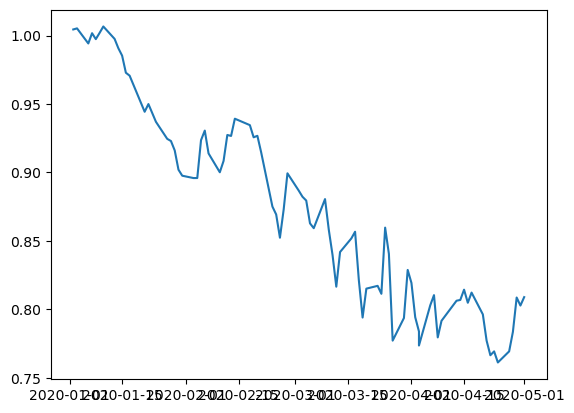

In [288]:
import matplotlib.pyplot as plt
plt.plot((residuals.iloc[69,:]+1).cumprod())

In [243]:
(residuals.iloc[0:10,:10]+1).cumprod(axis=1)

date,2004-01-02,2004-01-05,2004-01-06,2004-01-07,2004-01-08,2004-01-09,2004-01-12,2004-01-13,2004-01-14,2004-01-15
0,0.985646,0.975800,1.002513,1.003999,1.003380,1.009132,1.014647,1.010122,0.986169,1.004337
1,1.029399,1.047063,1.040187,1.027819,1.053729,1.017760,1.012232,1.016206,1.020855,1.009805
2,1.001360,0.991123,0.987781,0.991419,0.986452,0.986541,0.980528,0.988127,0.988615,0.989133
3,0.995711,0.986785,0.991201,0.985842,0.980019,0.982340,0.976821,0.980824,0.976767,0.974670
4,1.001533,1.002765,0.997787,0.984638,0.937695,0.920029,0.916390,0.921081,0.916832,0.944442
5,1.002568,0.997450,0.992741,0.993093,0.989935,0.991829,0.989304,0.992135,0.990618,0.989652
6,0.999736,1.003674,1.022530,1.028350,1.034520,1.011012,1.013648,0.990056,0.991124,1.033864
7,1.000826,0.991817,0.988989,0.987978,0.982425,0.985892,0.982031,0.985738,0.981045,0.980437
8,1.000143,1.007343,0.998814,0.991404,1.000461,0.977022,0.986220,1.014169,1.023822,1.026288
9,1.002455,0.997678,0.993330,0.993120,0.989946,0.993697,0.993118,0.993650,0.988551,0.988771


In [149]:
r_oos

date,2004-01-30,2004-02-27,2004-03-31,2004-04-30,2004-05-28,2004-06-30,2004-07-30,2004-08-31,2004-09-30,2004-10-29,2004-11-30,2004-12-31
PERMNO,,,,,,,,,,,,
80303,-0.039216,-0.008163,0.207819,-0.199319,-0.025532,0.150655,0.258065,-0.081448,0.339901,0.167892,0.354669,0.120837
10401,-0.041379,0.029291,-0.011108,-0.123659,-0.033236,-0.103287,0.032126,NaN,NaN,NaN,NaN,NaN
83976,0.048159,0.217375,0.077228,-0.070626,0.162321,0.063684,-0.048258,-0.237392,0.125000,0.243810,0.165773,0.030735
75107,0.108727,NaN,0.185239,0.395604,0.080490,0.018623,-0.141494,-0.098148,-0.091376,0.278531,NaN,0.017128
75510,-0.019639,-0.027415,0.055369,0.055980,0.075422,0.042180,-0.092903,0.087482,0.078755,0.132606,0.080850,0.036204
...,...,...,...,...,...,...,...,...,...,...,...,...
60097,0.012549,-0.047135,0.019669,0.056754,-0.050733,0.018867,0.019499,0.001611,0.044900,-0.015222,-0.059871,0.033715
29102,0.060241,0.076136,-0.033791,-0.030383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77649,0.119469,-0.004348,0.024216,-0.141085,0.035650,-0.016994,-0.088652,0.112840,-0.041084,-0.055150,0.103714,0.036713


In [143]:
weights.shape

(399, 399)

In [146]:
residuals

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [98]:
r_oos = y_oos.to_xarray().to_numpy() 

In [39]:
import os
import sys
import logging
#from utils import initialize_logging

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


def get_sharpe_tangencyPortfolio(returns): #returns has shape TxN
    if returns.shape[1] == 1:
        return np.abs(np.mean(returns))/np.std(returns)
    else:
        mean_ret = np.mean(returns, axis=0,keepdims=True)
        cov_ret = np.cov(returns.T)
        return float(np.sqrt(mean_ret @ np.linalg.solve(cov_ret,mean_ret.T)))


def get_tangencyPortfolio(returns): #returns has shape TxN
    if returns.shape[1] == 1:
        return 1
    else:
        mean_ret = np.mean(returns, axis=0,keepdims=True)
        cov_ret = np.cov(returns.T)
        weights = np.linalg.solve(cov_ret,mean_ret.T)
        return weights.T/np.sum(weights)


def preprocessMonthlyData(Data, _UNK = np.nan, normalizeCharacteristics = True, logdir=os.getcwd(), name = 'MonthlyData.npz'):
    if normalizeCharacteristics:
        DataChar = Data.iloc[:,[2]+list(range(5,Data.shape[1]))]
        grouped = DataChar.groupby('date')
        normalizedChar = grouped.transform(lambda x : x.rank(method='first')/x.count()-0.5)
        Data.iloc[:,5:] = normalizedChar
    else:
        name = name.replace(".npz", "Unnormalized.npz")

    savepath = os.path.join(logdir, name)
    if os.path.exists(savepath):
        print("Monthly characteristics data already processed; skipping")
        return
    
    Data.index = pd.MultiIndex.from_frame(Data[['date','permno']])
    Data = Data.drop(columns = Data.columns[range(0,4)])
    Data.sort_index(inplace=True) 
    shape = Data.index.levshape + tuple([len(Data.columns)])
    data = np.full(shape, _UNK)
    data[tuple(Data.index.codes)] = Data.values
    
    date = Data.index.levels[0].to_numpy()
    permno = Data.index.levels[1].to_numpy()
    variable = Data.columns.to_numpy()

    np.save(os.path.join(logdir, "permnos.npy"), permno)
    np.savez(savepath, data = data, date = date, permno = permno, variable = variable)
    return 


def preprocessDailyReturns(Data, RiskFreeRates, adjustRF = True, _UNK = np.nan, logdir=os.getcwd(), name = 'DailyReturns-RFadjusted.npz'):
    savepath = os.path.join(logdir, name)
    if os.path.exists(savepath):
        print("Daily returns already processed; skipping")
        return

    Data = Data[['date','permno','ret']]      
    Data.index = pd.MultiIndex.from_frame(Data[['date','permno']])
    Data = Data.drop(columns = Data.columns[range(0,2)])
    Data.sort_index(inplace=True) 
    shape = Data.index.levshape + tuple([len(Data.columns)])
    data = np.full(shape, _UNK)
    data[tuple(Data.index.codes)] = Data.values
    data = data[:,:,0]
    
    if adjustRF:
        data -= RiskFreeRates
    
    date = Data.index.levels[0].to_numpy()
    permno = Data.index.levels[1].to_numpy()

    # restrict returns data to only cover permnos that we have characteristics data for
    pmask = np.load(os.path.join(logdir, "permnos.npy"))
    data = data[:,np.isin(permno, pmask)]
    permno = pmask
    
    np.savez(savepath, data = data, date = date, permno = permno)
    return


class IPCA:
    def __init__(self, individual_feature_dim=46, logdir=os.getcwd(), debug=False,
                 pathMonthlyData = 'data/MonthlyData.npz', 
                 pathDailyData = 'data/DailyReturns-RFadjusted-new.npz', 
                 pathMonthlyDataUnnormalized = 'data/MonthlyDataUnnormalized.npz'):
        self._individual_feature_dim = individual_feature_dim #this is the number of characteristics, L
        self._logdir = logdir
        self._UNK = np.nan
        self._debug = debug
        
        monthlyData = np.load(pathMonthlyData, allow_pickle=True)
        dailyData = np.load(pathDailyData, allow_pickle=True)
        self.monthlyData = monthlyData['data']
        self.dailyData = dailyData['data']
        self.monthlyDataUnnormalized = np.load(pathMonthlyDataUnnormalized, allow_pickle=True)['data']
        self.monthlyCaps = np.nan_to_num(self.monthlyDataUnnormalized[:,:,19])
        
        self.dailyDates = pd.to_datetime(dailyData['date'], format='%Y%m%d')
        self.monthlyDates = pd.to_datetime(monthlyData['date'], format='%Y%m%d')
        # self.date2DailyIdx = {date:idx for idx, date in enumerate(self.dailyDates)}
        # self.date2MonthlyIdx = {date:idx for idx, date in enumerate(self.monthlyDates)}
        self.weight_matrices = []
        self.mask = np.zeros(0)
        self.weighted = False

    def _step_factor(self, R_list, I_list, Gamma, calculate_residual=False,startIndex=0):  # I are the characteristics Z in the paper
        f_list = []
        if calculate_residual:
            residual_list = []
        for (t, riTuple) in enumerate(zip(R_list, I_list)):
            R_t, I_t = riTuple
            beta_t = I_t.dot(Gamma)
            try:
                if self.weighted:
                    W_t = self.weight_matrices[t+startIndex]
                    A = beta_t.T @ W_t @ beta_t
                    f_t = np.linalg.solve(A, beta_t.T @ W_t @ R_t)
                else:
                    A = beta_t.T.dot(beta_t)
                    f_t = np.linalg.solve(A, beta_t.T.dot(R_t))
                    
            except np.linalg.LinAlgError as err:
                print(str(err))
                if self.weighted:
                    W_t = self.weight_matrices[t+startIndex]
                    f_t = np.linalg.pinv(beta_t.T @ W_t @ beta_t).dot(beta_t.T @ W_t @ R_t)
                else:
                    f_t = np.linalg.pinv(beta_t.T.dot(beta_t)).dot(beta_t.T.dot(R_t))
            f_list.append(f_t)
            if calculate_residual:
                residual_list.append(R_t - beta_t.dot(f_t))
        if calculate_residual:
            return f_list, residual_list
        else:
            return f_list, None

    def _step_gamma(self, R_list, I_list, f_list, nFactors,startIndex=0):
        A = np.zeros((self._individual_feature_dim * nFactors, self._individual_feature_dim * nFactors))
        b = np.zeros((self._individual_feature_dim * nFactors, 1))
        for (t, rifTuple) in enumerate(zip(R_list, I_list, f_list)):
            R_t, I_t, f_t = rifTuple
            tmp_t = np.kron(I_t, f_t.T)
            if self.weighted:
                W_t = self.weight_matrices[t+startIndex]
                A += tmp_t.T @ W_t @ tmp_t
                b += tmp_t.T @ W_t @ R_t
            else:
                A += tmp_t.T.dot(tmp_t)
                b += tmp_t.T.dot(R_t)
        try:
            Gamma = np.linalg.solve(A, b)
        except np.linalg.LinAlgError as err:
            print(str(err))
            Gamma = np.linalg.pinv(A).dot(b)
        return Gamma.reshape((self._individual_feature_dim, nFactors))

    def _initial_gamma(self, R_list, I_list, nFactors, startIndex = 0):   #added by Jorge
        T = len(R_list)
        X = np.zeros((T, self._individual_feature_dim))
        for t in range(T):
            if self.weighted:
                W_t = self.weight_matrices[t+startIndex]
                X[t,:] = np.squeeze(I_list[t].T @ W_t @ R_list[t]) / len(R_list[t])
            else:
                X[t,:] = np.squeeze(I_list[t].T.dot(R_list[t])) / len(R_list[t])
        eValues, eVectors = np.linalg.eig(X.T.dot(X))
        Gamma = eVectors[:,:nFactors]
        return Gamma
 
    def _initial_factors(self, R_list, I_list, nFactors, startIndex = 0):
        T = len(R_list)
        X = np.zeros((T, self._individual_feature_dim))
        for t in range(T):
            if self.weighted:
                W_t = self.weight_matrices[t+startIndex]
                X[t,:] = np.squeeze(I_list[t].T @ W_t @ R_list[t]) / len(R_list[t])
            else:
                X[t,:] = np.squeeze(I_list[t].T.dot(R_list[t])) / len(R_list[t])
        pca = PCA(n_components=nFactors)
        pca.fit(X.T)  # pca.components_ matrix is of shape nFactors x T
        f_list = pca.components_
        return np.split(f_list, f_list.shape[1], axis=1)  
    
    def matrix_debug(self, matrix, name, extra=False):
        if not self._debug:
            return
        nanct = np.sum(np.isnan(matrix))
        zeroct = matrix.size - np.count_nonzero(matrix)
        nanpct = nanct/matrix.size * 100
        zeropct = zeroct/matrix.size * 100
        print(f"'{name}' {matrix.shape}: has {matrix.size} entries and {nanct} NaNs ({nanpct:0.4f}%) and {zeroct} zeros ({zeropct:0.4f}%)")
        if extra:
            # also print which rows/columns are mostly/all NaNs
            nanrowcts = np.sum(np.isnan(matrix), axis=1)  # nans per row
            nancolcts = np.sum(np.isnan(matrix), axis=0)  # nans per column
            nanrowct = np.sum(nanrowcts > 0)  # number of rows in which there is 1+ NaN entries
            nancolct = np.sum(nancolcts > 0)  # number of cols in which there is 1+ NaN entries
            nanrowpct = nanrowct/matrix.shape[0]*100
            nancolpct = nancolct/matrix.shape[1]*100
            print(f"----> '{name}' {matrix.shape}: has {nanrowct} rows with NaNs ({nanrowpct:0.4f}%) and {nancolct} cols with NaNs ({nancolpct:0.4f}%)")
            nanidxs = np.argwhere(np.isnan(matrix))  # nan indices
            nancols = np.unique(nanidxs[:,1])  # column indices with nans
            # print(f"'{name}' {matrix.shape}: NaN columns are {nancols}")
            # print(f"'{name}' {matrix.shape}: NaN idxs are {nanidxs}")
            colnancts = {col: np.sum(nanidxs[:,1] == col) for col in nancols}
            print(f"----> '{name}' {matrix.shape}: NaNs counts in column indices (idx : count) {colnancts}")
            
    def nanl2norm(self, x):
        return np.sqrt(np.nansum(np.square(x)))
    
    def compute_sparse_residuals(self, full_residuals_month, beta_month, R_month_clean, sparsity_quantile_threshold=0.01):
        """
        Computes a set of sparse residuals closest to those in full_residuals_month by 
        solving a sparse approximation problem for returns in R_month_clean using
        a candidate set of permnos given by information in beta_month.
        
        E.g. if 
            S = full_residuals_month in R(T x P)
            R = R_month_clean        in R(T x P)
            P = proj(beta_month)     in R(P x P)
        and
            S = R(1-P)
        then we want to estimate a sparse matrix
            C in R(P x P)
        such that C is close to P in some norm and
            S ~= RC
            
        Currently, we solve that problem by
            1. Hard thresholding I-P by only keeping values greater in magnitude than the 
               99th quantile
            2. Extracting a set of permnos from the thresholded I-P, the index mask 'h'
            3. Using this candidate set of entries in each row of P as selected variables
               to solve the regression for C[h,i], column i of matrix C restricted to rows in h:
                   S[:,i] = R[:,h] * C[h,i]
               I.e. all indices of C[:,i] are zero except for those in 'h', and we only
               select columns of R which are in 'h'.
            4. Running this regression for each col of S for which card(R[:,h]) > 1
            5. Letting the sparse residuals for the month be defined as C * R
            
        Future ideas include:
            - better sparse approximation/recovery than hard thresholding + linear regression 
                (simple lasso regression, variations on OMP, (F)ISTA, etc.)
            - denoising S_i prior to approximation (e.g. solving the above regression 
                minimizing the L1 norm of error instead of by L2 norm (e.g. by least squares))
            - using information in factor weighting matrix more carefully, e.g. by computing sparse eigenvectors
                via sparse PCA or sparse robust PCA and using those to get reconstructed, sparse
                (I-)P instead of thresholding (I-)P; (can sparse I-P be seen as negative graph lap?)
            - thresholding returns as well? how would we do this consistently through time? perhaps
                returns would need to be normalized (by rolling stats) first, but why would r_t+1 be 
                near zero if r_t was? this may not be a realistic direction to explore.
            - making portfolios more consistent through time:
                - add penalty s.t. 
                    |C(t-1) - C(t)|_1 <= f(|R(t-1)'R(t-1) - R(t)'R(t)|_2, |Z(t-1)'Z(t-1) - Z(t)'Z(t)|_2)
                    where f is some sum, product, or ratio of the changes in volatility amongst R and Z 
                    in adjacent time periods
                - initialize with an initial hard thresholding or sparse robust PCA reconstruction
                    or lasso regression of (I-)P
            - learn sparsification over time given trading policy
                - make proportional to drawdown?
                - select thresholding parameter/sparsity penalty based on SCEMPC branch n bound?
                - include interaction with testing for mean reversion
            - learn way to filter out outliers in distributions of characteristics, or use heuristic:
                - market cap filter
                - volume
                - learn which permnos will be around next month from function of characteristics in prior months
        """
        # (1) do hard thresholding
        eye = np.identity(beta_month.shape[0])
        proj = eye - beta_month @ np.linalg.pinv(beta_month.T @ beta_month) @ beta_month.T
        # thresholding should only be done wrt observed (nonzero) returns' indices' weights, 
        # so we set columns of proj to zero if more than half of the respective return column is missing
        # get idxs of columns where more than half of R_month_clean is zero
        mostly_zero_returns_col_idxs = np.argwhere(np.count_nonzero(R_month_clean, axis=0) <= R_month_clean.shape[0]//2).ravel()
        # set those columns in proj to zero
        proj[:,mostly_zero_returns_col_idxs] = 0
        threshold = np.quantile(np.abs(proj), 1 - sparsity_quantile_threshold)
        np.putmask(proj, np.abs(proj) < threshold, 0)  
        # mplot = plt.imshow((np.abs(proj) < threshold).T, interpolation='nearest', aspect='auto')
        # plt.savefig(f"test-sparse-proj-{beta_month.shape[1]}-{R_month_clean.shape[0]}-{R_month_clean.shape[1]}.png")
        # (2) print stats and such
        if np.random.rand() > 0.9:
            #print(proj.shape, R_month_clean.shape, beta_month.shape, full_residuals_month.shape)
            nonzero_portfolios = R_month_clean @ (eye - proj)
            num_nonzero_portfolios = np.sum(np.count_nonzero(nonzero_portfolios, axis=0) >= nonzero_portfolios.shape[0] * 0.9)
            #print(num_nonzero_portfolios, "portfolios (not containing self weight) left of", len(proj), 
                 # f"({num_nonzero_portfolios / len(proj) * 100:0.2f}% preserved)")
            nonzero_portfolios = R_month_clean @ proj
            num_nonzero_portfolios = np.sum(np.count_nonzero(nonzero_portfolios, axis=0) >= nonzero_portfolios.shape[0] * 0.9)
            #print(num_nonzero_portfolios, "portfolios left of", len(proj), 
                 # f"({num_nonzero_portfolios / len(proj) * 100:0.2f}% preserved)")
            ps = np.sum(np.abs(proj) > 0, axis=1)  # portfolio sizes
            ps = ps[ps > 0]
           # print("Size stats: ", "mean", np.mean(ps), "median", np.median(ps), "min", np.min(ps), 
                 # "max", np.max(ps), "q99", np.quantile(ps, 0.99), "num2to6:", np.sum((1 < ps) & (ps <= 6)))
            # the rows which include the permno itself (that is, the diagonal entry is nonzero)
            include_self_idxs = np.argwhere(np.diag(np.abs(proj)) > 1e-12).ravel()
            num_include_self = min(len(include_self_idxs), num_nonzero_portfolios)
            #print(f"Out of the {num_nonzero_portfolios} portfolios left, {num_include_self} include" + \
                 # f" themselves ({num_include_self/num_nonzero_portfolios*100:0.2f}%)")
            # out of the rows which include the permno itself, 
            # how many are comprised ONLY of the permno itself 
            # (e.g. they have one nonzero entry, which should be the permno's weight)
            num_just_self = np.sum(np.count_nonzero(proj[include_self_idxs,:], axis=1) == 1)
            #print(f"Out of the {num_nonzero_portfolios} portfolios left, {num_just_self} are " + \
                  #f"comprised of just one permno only: itself ({num_just_self/num_nonzero_portfolios*100:0.2f}%)")
        # (3) now perform regression and return sparse residuals
        C = np.zeros_like(proj)
        for i in range(proj.shape[0]):
            # get indices of nonzero weights
            h = np.argwhere(proj[:,i] != 0).ravel()
            if len(h) == 0:
                continue
            elif len(h) == 1:
                if h[0] == i:
                    C[i,i] = 1
                    continue
                else:
                    #print("Hard thresholding got single weight which is not permno itself!")
                    continue
            Rh = R_month_clean[:,h]
            Si = full_residuals_month[:,i]
            if np.linalg.norm(Rh) <= 1e-8:
                pass
            C[h,i] = np.linalg.pinv(Rh.T.dot(Rh)).dot(Rh.T.dot(Si))
        return C
    
    def compute_weight_matrices(self, mask):
        """
        Computes a T-long sequence of NtxNt weight matrices Wt for the daily returns and mask provided,
        where Nt is the number of permnos in a given month and T is the number of months.
        Currently, only implements equal observation volatility weighting.
        """   
        weight_matrices = []
        for month in range(len(self.monthlyDates)):
            if month == 0:
                idxs_days_month = (self.dailyDates <= self.monthlyDates[0])
            else:
                idxs_days_month = (self.dailyDates > self.monthlyDates[month-1]) & (self.dailyDates <= self.monthlyDates[month])
            rmonth = self.dailyData[:,mask[month,:]][idxs_days_month,:]  # TtxNt matrix
            nans_per_col = np.count_nonzero(np.isnan(rmonth),axis=0)
            #nanszeros_per_col = np.count_nonzero(np.isnan(rmonth),axis=0) + np.sum(rmonth==0,axis=0)
            insufficient_data_mask = nans_per_col >= np.round(0.9 * rmonth.shape[0])
            vols = np.nanvar(rmonth, axis=0) #* rmonth.shape[0]  # Nt long vector
            vols[insufficient_data_mask] = np.nan 
            weight_mtx = np.diag(1/vols)
            weight_mtx[~np.isfinite(weight_mtx)] = 0
            weight_mtx[weight_mtx >= 10**6] = 0
            weight_matrices.append(weight_mtx)

        return weight_matrices
    
    def MonthlyOOSExpandingWindow(self, save=True, listFactors=list(range(1,21)), maxIter=1024, printOnConsole=True, printFreq=8, tol=1e-03,initialMonths=30*12,sizeWindow=24*12,CapProportion=0):
        R = self.monthlyData[:,:,0]
        I = self.monthlyData[:,:,1:]
        cap_chosen_idxs = self.monthlyCaps/np.nansum(self.monthlyCaps,axis=1,keepdims=True) >= CapProportion*0.01
        mask = (~np.isnan(R)) * cap_chosen_idxs
        R_reshape = np.expand_dims(R[mask], axis=1)
        I_reshape = I[mask]
        splits = np.sum(mask, axis=1).cumsum()[:-1]  #np.sum(mask, axis=1) how many stocks we have per year; the other cumukatively except for the last one
        R_list = np.split(R_reshape, splits)
        I_list = np.split(I_reshape, splits)
        nWindows = int((R.shape[0] - initialMonths)/sizeWindow)

        for nFactors in listFactors:
            residualsOOS = np.zeros_like(R[initialMonths:,:], dtype=float)
            for nWindow in range(nWindows):
                if nWindow == 0:
                    f_list = self._initial_factors(R_list[:initialMonths], I_list[:initialMonths], nFactors)
                    self._Gamma = np.zeros((self._individual_feature_dim, nFactors))
                    nIter = 0
                    while nIter < maxIter:
                        Gamma = self._step_gamma(R_list[:initialMonths], I_list[:initialMonths], f_list, nFactors)
                        f_list, _ = self._step_factor(R_list[:initialMonths], I_list[:initialMonths],Gamma)
                        nIter += 1
                        dGamma = np.max(np.abs(self._Gamma - Gamma))
                        self._Gamma = Gamma
                        if printOnConsole and nIter % printFreq == 0:
                            print('nFactor: %d\t, nWindow: %d/%d\t, nIter: %d\t, dGamma: %0.2e' %(nFactors,nWindow,nWindows,nIter,dGamma))
                        if nIter > 1 and dGamma < tol:
                            break
                else:
                    nIter = 0
                    while nIter < maxIter:
                        f_list, _ = self._step_factor(R_list[:(initialMonths+nWindow*sizeWindow)], I_list[:(initialMonths+nWindow*sizeWindow)],self._Gamma)
                        Gamma = self._step_gamma(R_list[:(initialMonths+nWindow*sizeWindow)], I_list[:(initialMonths+nWindow*sizeWindow)], f_list, nFactors)
                        nIter += 1
                        dGamma = np.max(np.abs(self._Gamma - Gamma))
                        self._Gamma = Gamma
                        if printOnConsole and nIter % printFreq == 0:
                            print('nFactor: %d\t, nWindow: %d/%d\t, nIter: %d\t, dGamma: %0.2e' %(nFactors,nWindow,nWindows,nIter,dGamma))
                        if nIter > 1 and dGamma < tol:
                            break
                    
                f_list, residual_list = self._step_factor(R_list[(initialMonths+nWindow*sizeWindow):(initialMonths+(nWindow+1)*sizeWindow)], I_list[(initialMonths+nWindow*sizeWindow):(initialMonths+(nWindow+1)*sizeWindow)], self._Gamma, calculate_residual=True)
                residualsOOS[(nWindow*sizeWindow):((nWindow+1)*sizeWindow),:][mask[(initialMonths+nWindow*sizeWindow):(initialMonths+(nWindow+1)*sizeWindow),:]] = np.squeeze(np.concatenate(residual_list))
                
            if printOnConsole:                
                print('Finished! (nFactors = %d)' %nFactors)
            if save:
                np.save(os.path.join(self._logdir, 'IPCA_OOSresiduals_%d_factors_%d_initialMonths_%d_window.npy' %(nFactors,initialMonths,sizeWindow)), residualsOOS)
        return residualsOOS
        
    # CapProportion = 0.001, 0.01  #The betas are going to be constant each month, so essentially constant at the daily level (and the factors will change daily)
    # SizeWindow must divide  = months of Data - training months
        
    def DailyOOSRollingWindow(self, save=True, weighted=True, listFactors=list(range(1,21)), maxIter=1024, 
                                printOnConsole=True, printFreq=8, tol=1e-03, initialMonths=35*12, 
                                sizeWindow=15*12, CapProportion = 0.001, save_beta=False, save_gamma=False, 
                                save_rmonth=False, save_mask=False, save_sparse_weights_month=False,
                                skip_oos=False,reestimationFreq = 12):    
        matrix_debug = self.matrix_debug
        R = self.monthlyData[:,:,0]
        I = self.monthlyData[:,:,1:]
        cap_chosen_idxs = self.monthlyCaps/np.nansum(self.monthlyCaps,axis=1,keepdims=True) >= CapProportion*0.01
        mask = (~np.isnan(R)) * cap_chosen_idxs
        self.mask = mask
        if save_mask:
            mask_path = os.path.join(self._logdir, f"mask_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
            np.save(mask_path, mask)
        # with np.printoptions(threshold=np.inf):      
        #     print(np.count_nonzero(mask,axis=1))                  
        R_reshape = np.expand_dims(R[mask], axis=1)
        I_reshape = I[mask]
        splits = np.sum(mask, axis=1).cumsum()[:-1]  #np.sum(mask, axis=1) how many stocks we have per year; the other cumukatively except for the last one
        R_list = np.split(R_reshape, splits)
        I_list = np.split(I_reshape, splits)
        self.R_list = R_list
        self.I_list = I_list
        nWindows = int((R.shape[0] - initialMonths)/reestimationFreq)
        print(f"nWindows {nWindows}")
        
        if weighted:
            self.weighted = True
            self.weight_matrices = self.compute_weight_matrices(mask)
        
        firstOOSDailyIdx = np.argmax(self.dailyDates >= (pd.datetime(self.dailyDates.year[0],self.dailyDates.month[0],1)+pd.DateOffset(months=initialMonths)))
        print(f"firstidx {firstOOSDailyIdx}")
        print(f"self.dailyData.shape[0] {self.dailyData.shape[0]}")
        Rdaily = self.dailyData[firstOOSDailyIdx:,:]
        sharpesFactors = np.zeros(len(listFactors))
        counter = 0
        
        DataTrain = np.load(os.path.join('residuals', 'ipca_normalized', f"IPCA_DailyOOSresiduals_1_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap.npy"))
        assetsToConsider = np.count_nonzero(DataTrain, axis=0) >= 30 #chooses stocks which have at least #lookback non-missing observations in all the training time
        print(np.where(assetsToConsider))
        print(f"sum a2c {np.sum(assetsToConsider)}")
        Ntilde = np.sum(assetsToConsider)  # the residuals we are actually going to trade
        T,N = Rdaily.shape
        print(f'N {N} Ntilde {Ntilde}')
        superMask = np.count_nonzero(mask[initialMonths-1:],axis=0)>=1
        Nsupertilde = np.sum(superMask)  # the maximum assets that are going to be involved in the interesting residuals
        print(f"superMask {superMask.shape} {Nsupertilde} {len(superMask)}")
        np.save('residuals-new/super_mask.npy',superMask)
        
        if not os.path.isdir(self._logdir + "_stuff"):
            try:
                os.mkdir(self._logdir + "_stuff")
            except Exception as e:
                print(f"Could not create folder '{self._logdir + '_stuff'}'!")
                raise e

        if printOnConsole:
            print("Beginning daily residual computations")
        for nFactors in listFactors:
            residualsOOS = np.zeros_like(Rdaily, dtype=float)
            factorsOOS = np.zeros_like(Rdaily[:,:nFactors], dtype=float)
            sparse_oos_residuals = np.zeros_like(Rdaily, dtype=float)
            T,N=residualsOOS.shape
            residualsMatricesOOS = np.zeros((T,Ntilde,Nsupertilde), dtype=np.float32)
            
            # WeightsFactors = np.zeros((T,N,N))
            # WeightsSparseFactors = np.zeros((T,N,N))
            if nFactors == 0:
                for month in range((initialMonths),R.shape[0]):
                    idxs_days_month = (self.dailyDates[firstOOSDailyIdx:] >  self.monthlyDates[month-1]) \
                                    & (self.dailyDates[firstOOSDailyIdx:] <= self.monthlyDates[month])
                    R_month = Rdaily[:,mask[month-1,:]][idxs_days_month,:] #TxN
                    # change missing values to zeros to exclude them from calculation
                    R_month_clean = R_month.copy()
                    R_month_clean[np.isnan(R_month_clean)] = 0
                    residuals_month = R_month
                    # set residuals equal to zero wherever there are NaNs from missing returns, as (NaN - prediction) is still NaN
                    residuals_month[np.isnan(residuals_month)] = 0
                    sparse_residuals_month = residuals_month
                    temp = residualsOOS[:,mask[month-1,:]].copy()
                    temp[idxs_days_month,:] = residuals_month
                    residualsOOS[:,mask[month-1,:]] = temp
                    sparse_temp = sparse_oos_residuals[:,mask[month-1,:]].copy()
                    sparse_temp[idxs_days_month,:] = sparse_residuals_month
                    sparse_oos_residuals[:,mask[month-1,:]] = sparse_temp
            else:
                for nWindow in range(nWindows):         
                    # Load or estimate Gamma; use save_gamma=True to force estimation
                    # Gamma estimation
                    print("Estimating gamma")
                    if nWindow == 0:
                        gamma_path = os.path.join(self._logdir+'_stuff', f"gamma_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap_{nWindow}.npy")
                        if os.path.isfile(gamma_path) and not save_gamma:
                            Gamma = np.load(gamma_path)
                            self._Gamma = Gamma
                        else:
                            f_list = self._initial_factors(R_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], I_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], nFactors,startIndex=initialMonths+nWindow*reestimationFreq-sizeWindow)
                            self._Gamma = np.zeros((self._individual_feature_dim, nFactors))
                            nIter = 0
                            while nIter < maxIter:
                                Gamma = self._step_gamma(R_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], I_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], f_list, nFactors,startIndex=initialMonths+nWindow*reestimationFreq-sizeWindow)
                                f_list, _ = self._step_factor(R_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], I_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], Gamma,startIndex=initialMonths+nWindow*reestimationFreq-sizeWindow)
                                nIter += 1
                                dGamma = np.max(np.abs(self._Gamma - Gamma))
                                self._Gamma = Gamma
                                if printOnConsole and nIter % printFreq == 0:
                                    print('nFactor: %d,\t nWindow: %d/%d,\t nIter: %d,\t dGamma: %0.2e' % (nFactors,nWindow,nWindows,nIter,dGamma))
                                if nIter > 1 and dGamma < tol:
                                    break
                            if save_gamma:                            
                                np.save(gamma_path, Gamma)
                    else:
                        gamma_path = os.path.join(self._logdir+'_stuff', f"gamma_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap_{nWindow}.npy")
                        if os.path.isfile(gamma_path) and not save_gamma:
                            Gamma = np.load(gamma_path)
                            self._Gamma = Gamma
                        else:
                            nIter = 0
                            while nIter < maxIter/2:
                                f_list, _ = self._step_factor(R_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], I_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], self._Gamma,startIndex=initialMonths+nWindow*reestimationFreq-sizeWindow)
                                Gamma = self._step_gamma(R_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], I_list[(initialMonths+nWindow*reestimationFreq-sizeWindow):(initialMonths+nWindow*reestimationFreq)], f_list, nFactors,startIndex=initialMonths+nWindow*reestimationFreq-sizeWindow)
                                nIter += 1
                                dGamma = np.max(np.abs(self._Gamma - Gamma))
                                self._Gamma = Gamma
                                if printOnConsole and nIter % printFreq == 0:
                                    print('nFactor: %d,\t nWindow: %d/%d,\t nIter: %d,\t dGamma: %0.2e' %(nFactors,nWindow,nWindows,nIter,dGamma))
                                if nIter > 1 and dGamma < tol:
                                    break
                            if save_gamma:
                                np.save(gamma_path, Gamma)

                    if not skip_oos:
                        # Computation of out-of-sample residuals   
                        for month in range((initialMonths+nWindow*reestimationFreq),(initialMonths+(nWindow+1)*reestimationFreq)):
                            if self._debug: print(f"--- Month: {month}/{(initialMonths+(nWindow+1)*sizeWindow)} ----")
                            beta_month = I[month-1,mask[month-1,:]].dot(self._Gamma)  # N x nfactors
                            # self.matrix_debug(beta_month, "beta_month")
                            idxs_days_month = (self.dailyDates[firstOOSDailyIdx :] > self.monthlyDates[month-1]) \
                                            & (self.dailyDates[firstOOSDailyIdx:] <= self.monthlyDates[month])
                            R_month = Rdaily[:,mask[month-1,:]][idxs_days_month,:] #TxN
                            if save_rmonth:
                                r_path = os.path.join(self._logdir+'_stuff', f"rmonth_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap.npy")
                                np.save(r_path, R_month)
                            # change missing values to zeros to exclude them from calculation
                            R_month_clean = R_month.copy()
                            R_month_clean[np.isnan(R_month_clean)] = 0
                            
                            # try:
                            #     if weighted:
                            #         W_month = self.weight_matrices[month-1]
                            #         factors_month = np.linalg.solve(beta_month.T @ W_month @ beta_month, beta_month.T @ W_month @ R_month_clean.T) # nfactors x T
                            #     else:
                            #         factors_month = np.linalg.solve(beta_month.T.dot(beta_month), beta_month.T.dot(R_month_clean.T)) # nfactors x T
                            #         #factors_month = np.linalg.solve(beta_month.T.dot(beta_month), beta_month.T.dot(R_month.T)) # nfactors x T
                            # except np.linalg.LinAlgError as err:
                            
                            if weighted:
                                factors_month = np.linalg.pinv(beta_month.T @ W_month @ beta_month).dot(beta_month.T @ W_month @ R_month_clean.T) # nfactors x T
                            else:
                                factors_month = np.linalg.pinv(beta_month.T @ beta_month).dot(beta_month.T @ R_month_clean.T) # nfactors x T
                            residuals_month = R_month - factors_month.T.dot(beta_month.T)
                            # set residuals equal to zero wherever there are NaNs from missing returns, as (NaN - prediction) is still NaN
                            # residuals_month2 = residuals_month.copy()
                            residuals_month[np.isnan(residuals_month)] = 0
                            # print(np.sum(residuals_month2*~np.isnan(R_month)),np.sum(np.isnan(residuals_month)))
                            # print(np.linalg.norm(residuals_month2*~np.isnan(R_month)-residuals_month))
                            
                            sparse_weights_month = self.compute_sparse_residuals(residuals_month, beta_month, R_month_clean)
                            sparse_residuals_month = R_month_clean @ sparse_weights_month
                            if save_sparse_weights_month:
                                sw_path = os.path.join(self._logdir+'_stuff', f"sparseweights_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap.npy")
                                np.save(sw_path, sparse_weights_month)
                            if save_beta:
                                beta_path = os.path.join(self._logdir+'_stuff', f"beta_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap.npy")
                                np.save(beta_path, beta_month)
                            #self.matrix_debug(residuals_month, "residuals_month", extra=True)
                            
                            temp = residualsOOS[:,mask[month-1,:]].copy()
                            temp[idxs_days_month,:] = residuals_month
                            residualsOOS[:,mask[month-1,:]] = temp
                            sparse_temp = sparse_oos_residuals[:,mask[month-1,:]].copy()
                            sparse_temp[idxs_days_month,:] = sparse_residuals_month
                            sparse_oos_residuals[:,mask[month-1,:]] = sparse_temp
                            factorsOOS[idxs_days_month,:] = factors_month.T
                                                         
                            Tprime,Nprime = R_month_clean.shape
                            MatrixFull = np.zeros((Tprime,N,N))
                            MatrixReduced = np.nan_to_num(np.eye(Nprime)-beta_month@np.linalg.pinv(beta_month.T @ beta_month)@beta_month.T).T # Nprime x Nprime
                            mask_month = np.broadcast_to(~np.isnan(R_month).reshape((Tprime,Nprime,1)),(Tprime,Nprime,Nprime))
                            # print(np.matmul(mask_month*np.broadcast_to(MatrixReduced,(Tprime,Nprime,Nprime)),R_month_clean.reshape((Tprime,Nprime,1))).squeeze().shape,residuals_month.shape)
                            # print(np.linalg.norm(np.matmul(mask_month*np.broadcast_to(MatrixReduced,(Tprime,Nprime,Nprime)),R_month_clean.reshape((Tprime,Nprime,1))).squeeze()-residuals_month))
                            # print(np.linalg.norm(np.nan_to_num(MatrixReduced@R_month.T-residuals_month.T)))
                            # print(MatrixFull[np.broadcast_to(mask[month-1,:].reshape((N,1))@mask[month-1,:].reshape((1,N)),(Tprime,N,N))].shape)
                            MatrixFull[np.broadcast_to(mask[month-1,:].reshape((N,1))@mask[month-1,:].reshape((1,N)),(Tprime,N,N))] = (mask_month*np.broadcast_to(MatrixReduced,(Tprime,Nprime,Nprime))).ravel()
                            # print(np.linalg.norm(np.matmul(MatrixFull,np.nan_to_num(Rdaily[idxs_days_month].reshape((Tprime,N,1)))).squeeze()-residualsOOS[idxs_days_month]))
                            residualsMatricesOOS[idxs_days_month] = MatrixFull[:,assetsToConsider][:,:,superMask]
                            # print(residualsMatricesOOS[idxs_days_month].shape)
                            portfolio1 = residualsOOS[idxs_days_month][:,assetsToConsider]
                            portfolio2 = np.matmul(residualsMatricesOOS[idxs_days_month], np.nan_to_num(Rdaily[idxs_days_month][:,superMask]).reshape(Tprime,Nsupertilde,1)).squeeze()
                            transition_error = np.linalg.norm(portfolio1 - portfolio2) / Tprime
                            print(transition_error)
                            # print('New month!')

                            # MatrixFull = np.zeros((N,N))
                            # MatrixFull[mask[month-1,:].reshape((N,1))@mask[month-1,:].reshape((1,N))] = np.nan_to_num(sparse_weights_month.T.ravel())
                            # residualsMatricesOOS[idxs_days_month] = np.broadcast_to(MatrixFull[assetsToConsider][:,assetsToConsider],(np.sum(idxs_days_month),Ntilde,Ntilde))
                            # print(np.linalg.norm(sparse_oos_residuals[idxs_days_month][:,assetsToConsider]-np.matmul(residualsMatricesOOS[idxs_days_month],np.nan_to_num(Rdaily[idxs_days_month][:,assetsToConsider],copy=False).reshape(Tprime,Ntilde,1)).squeeze())/Tprime)    
                            
                            # if printOnConsole and random.random() > 0.9:
                            #     rel_approx_error = self.nanl2norm(temp - sparse_temp) / self.nanl2norm(temp)
                            #     print(f"----> Sparse portfolio relative approximation error is {rel_approx_error*100:0.4f}%")
                            #     self.matrix_debug(residualsOOS, "residualsOOS")
                            #     self.matrix_debug(sparse_oos_residuals, "sparse_oos_residuals")
                
                if not skip_oos:
                    factorsOOS = np.nan_to_num(factorsOOS)
                    sharpesFactors[counter] = get_sharpe_tangencyPortfolio(factorsOOS)
                    counter += 1
                    
            if printOnConsole:                
                print('Finished (nFactors = %d)' %nFactors)
            if save and not skip_oos:
                rsavepath = os.path.join(self._logdir, f"IPCA_DailyOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                msavepath = os.path.join(self._logdir, f"IPCA_DailyMatrixOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                print(f"Saving {rsavepath}")
                np.save(rsavepath, residualsOOS)
                # np.save(os.path.join(self._logdir, f"IPCA_sparseDailyOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy"), sparse_oos_residuals)
                print(f"Saving {msavepath}")
                np.save(msavepath, residualsMatricesOOS)
                # np.save(os.path.join(self._logdir, f"IPCA_sparseDailyMatrixOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy"), sparse_oos_residuals)                
        if not skip_oos:
            pass
            # np.savetxt(os.path.join(self._logdir,f"IPCA_DailyOOSFactorsSharpes_{initialMonths}_initialMonths_{sizeWindow}_window_{reestimationFreq}_reestimationFreq_{CapProportion}_cap.csv"),sharpesFactors,delimiter=',',header = f"Factors: {listFactors}")
            
        return
    
    def DailyOOSExpandingWindow(self, save=True, weighted=True, listFactors=list(range(1,21)), maxIter=1024, 
                                printOnConsole=True, printFreq=8, tol=1e-03, initialMonths=30*12, 
                                sizeWindow=24*12, CapProportion = 0.001, save_beta=False, save_gamma=False, 
                                save_rmonth=False, save_mask=False, save_sparse_weights_month=False,
                                skip_oos=False):    
        matrix_debug = self.matrix_debug
        R = self.monthlyData[:,:,0]
        I = self.monthlyData[:,:,1:]
        cap_chosen_idxs = self.monthlyCaps/np.nansum(self.monthlyCaps,axis=1,keepdims=True) >= CapProportion*0.01
        mask = (~np.isnan(R)) * cap_chosen_idxs
        self.mask = mask
        if save_mask:
            mask_path = os.path.join(self._logdir, f"mask_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
            np.save(mask_path, mask)
        with np.printoptions(threshold=np.inf):
            print(np.count_nonzero(mask,axis=1))                  
        R_reshape = np.expand_dims(R[mask], axis=1)
        I_reshape = I[mask]
        splits = np.sum(mask, axis=1).cumsum()[:-1]  #np.sum(mask, axis=1) how many stocks we have per year; the other cumukatively except for the last one
        R_list = np.split(R_reshape, splits)
        I_list = np.split(I_reshape, splits)
        self.R_list = R_list
        self.I_list = I_list
        nWindows = int((R.shape[0] - initialMonths)/sizeWindow)
        print(f"nWindows {nWindows}")
        
        if weighted:
            self.weighted = True
            self.weight_matrices = self.compute_weight_matrices(mask)
        
        firstOOSDailyIdx = np.argmax(self.dailyDates >= (pd.datetime(self.dailyDates.year[0],self.dailyDates.month[0],1)+pd.DateOffset(months=initialMonths)))
        print(f"firstidx {firstOOSDailyIdx}")
        print(f"self.dailyData.shape[0] {self.dailyData.shape[0]}")
        Rdaily = self.dailyData[firstOOSDailyIdx:,:]
        sharpesFactors = np.zeros(len(listFactors))
        counter = 0
        
        if not os.path.isdir(self._logdir + "_stuff"):
            try:
                os.mkdir(self._logdir + "_stuff")
            except Exception as e:
                print(f"Could not create folder '{self._logdir + '_stuff'}'!")
                raise e

        if printOnConsole:
            print("Beginning daily residual computations")
        for nFactors in listFactors:
            residualsOOS = np.zeros_like(Rdaily, dtype=float)
            factorsOOS = np.zeros_like(Rdaily[:,:nFactors], dtype=float)
            sparse_oos_residuals = np.zeros_like(Rdaily, dtype=float)
            T,N=residualsOOS.shape
            #WeightsFactors = np.zeros((T,N,N))
            #WeightsSparseFactors = np.zeros((T,N,N))
            for nWindow in range(nWindows):
                if nFactors == 0:
                    for month in range((initialMonths+nWindow*sizeWindow),(initialMonths+(nWindow+1)*sizeWindow)):
                        idxs_days_month = (self.dailyDates[firstOOSDailyIdx :] > self.monthlyDates[month-1]) \
                                            & (self.dailyDates[firstOOSDailyIdx:] <= self.monthlyDates[month])
                        R_month = Rdaily[:,mask[month-1,:]][idxs_days_month,:] #TxN
                        # change missing values to zeros to exclude them from calculation
                        R_month_clean = R_month.copy()
                        R_month_clean[np.isnan(R_month_clean)] = 0
                        residuals_month = R_month
                        # set residuals equal to zero wherever there are NaNs from missing returns, as (NaN - prediction) is still NaN
                        residuals_month[np.isnan(residuals_month)] = 0
                        sparse_residuals_month = residuals_month
                        temp = residualsOOS[:,mask[month-1,:]].copy()
                        temp[idxs_days_month,:] = residuals_month
                        residualsOOS[:,mask[month-1,:]] = temp
                        sparse_temp = sparse_oos_residuals[:,mask[month-1,:]].copy()
                        sparse_temp[idxs_days_month,:] = sparse_residuals_month
                        sparse_oos_residuals[:,mask[month-1,:]] = sparse_temp
                    
                else:          
                    # Load or estimate Gamma; use save_gamma=True to force estimation
                    gamma_path = os.path.join(self._logdir+'_stuff', f"gamma_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                    if os.path.isfile(gamma_path) and not save_gamma:
                        Gamma = np.load(gamma_path)
                        self._Gamma = Gamma
                    # Gamma estimation
                    else:
                        print("Estimating gamma")
                        if nWindow == 0:
                            f_list = self._initial_factors(R_list[:initialMonths], I_list[:initialMonths], nFactors)
                            self._Gamma = np.zeros((self._individual_feature_dim, nFactors))
                            nIter = 0
                            while nIter < maxIter:
                                Gamma = self._step_gamma(R_list[:initialMonths], I_list[:initialMonths], f_list, nFactors)
                                f_list, _ = self._step_factor(R_list[:initialMonths], I_list[:initialMonths], Gamma)
                                nIter += 1
                                dGamma = np.max(np.abs(self._Gamma - Gamma))
                                self._Gamma = Gamma
                                if printOnConsole and nIter % printFreq == 0:
                                    print('nFactor: %d,\t nWindow: %d/%d,\t nIter: %d,\t dGamma: %0.2e' %(nFactors,nWindow,nWindows,nIter,dGamma))
                                if nIter > 1 and dGamma < tol:
                                    break
                        else:
                            nIter = 0
                            while nIter < maxIter:
                                f_list, _ = self._step_factor(R_list[:(initialMonths+nWindow*sizeWindow)], I_list[:(initialMonths+nWindow*sizeWindow)], self._Gamma)
                                Gamma = self._step_gamma(R_list[:(initialMonths+nWindow*sizeWindow)], I_list[:(initialMonths+nWindow*sizeWindow)], f_list, nFactors)
                                nIter += 1
                                dGamma = np.max(np.abs(self._Gamma - Gamma))
                                self._Gamma = Gamma
                                if printOnConsole and nIter % printFreq == 0:
                                    print('nFactor: %d,\t nWindow: %d/%d,\t nIter: %d,\t dGamma: %0.2e' %(nFactors,nWindow,nWindows,nIter,dGamma))
                                if nIter > 1 and dGamma < tol:
                                    break
                        if save_gamma:
                            gamma_path = os.path.join(self._logdir+'_stuff', f"gamma_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                            np.save(gamma_path, Gamma)

                    if not skip_oos:
                        # Computation of out-of-sample residuals   
                        for month in range((initialMonths+nWindow*sizeWindow),(initialMonths+(nWindow+1)*sizeWindow)):
                            if self._debug: print(f"--- Month: {month}/{(initialMonths+(nWindow+1)*sizeWindow)} ----")
                            beta_month = I[month-1,mask[month-1,:]].dot(self._Gamma)  # N x nfactors
                            #self.matrix_debug(beta_month, "beta_month")
                            idxs_days_month = (self.dailyDates[firstOOSDailyIdx :] > self.monthlyDates[month-1]) \
                                            & (self.dailyDates[firstOOSDailyIdx:] <= self.monthlyDates[month])
                            R_month = Rdaily[:,mask[month-1,:]][idxs_days_month,:] #TxN
                            if save_rmonth:
                                r_path = os.path.join(self._logdir+'_stuff', f"rmonth_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                                np.save(r_path, R_month)
                            # change missing values to zeros to exclude them from calculation
                            R_month_clean = R_month.copy()
                            R_month_clean[np.isnan(R_month_clean)] = 0
                            try:
                                if weighted:
                                    W_month = self.weight_matrices[month-1]
                                    factors_month = np.linalg.solve(beta_month.T @ W_month @ beta_month, beta_month.T @ W_month @ R_month_clean.T) # nfactors x T
                                else:
                                    factors_month = np.linalg.solve(beta_month.T.dot(beta_month), beta_month.T.dot(R_month_clean.T)) # nfactors x T
                                    #factors_month = np.linalg.solve(beta_month.T.dot(beta_month), beta_month.T.dot(R_month.T)) # nfactors x T
                            except np.linalg.LinAlgError as err:
                                print(f"----> Linear algebra error: {str(err)}")
                                if weighted:
                                    factors_month = np.linalg.pinv(beta_month.T @ W_month @ beta_month).dot(beta_month.T @ W_month @ R_month.T) # nfactors x T
                                else:
                                    factors_month = np.linalg.pinv(beta_month.T @ beta_month).dot(beta_month.T @ R_month.T) # nfactors x T
                            residuals_month = R_month - factors_month.T.dot(beta_month.T)
                            # set residuals equal to zero wherever there are NaNs from missing returns, as (NaN - prediction) is still NaN
                            residuals_month[np.isnan(residuals_month)] = 0
                            sparse_weights_month = self.compute_sparse_residuals(residuals_month, beta_month, R_month_clean)
                            sparse_residuals_month = R_month_clean @ sparse_weights_month
                            if save_sparse_weights_month:
                                sw_path = os.path.join(self._logdir+'_stuff', f"sparseweights_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                                np.save(sw_path, sparse_weights_month)
                            if save_beta:
                                beta_path = os.path.join(self._logdir+'_stuff', f"beta_{month}_month_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                                np.save(beta_path, beta_month)
                            #self.matrix_debug(residuals_month, "residuals_month", extra=True)
                            temp = residualsOOS[:,mask[month-1,:]].copy()
                            temp[idxs_days_month,:] = residuals_month
                            residualsOOS[:,mask[month-1,:]] = temp
                            sparse_temp = sparse_oos_residuals[:,mask[month-1,:]].copy()
                            sparse_temp[idxs_days_month,:] = sparse_residuals_month
                            sparse_oos_residuals[:,mask[month-1,:]] = sparse_temp
                            factorsOOS[idxs_days_month,:] = factors_month.T

                            if printOnConsole:
                                #rel_approx_error = self.nanl2norm(temp - sparse_temp) / self.nanl2norm(temp)
                                #print(f"----> Sparse portfolio relative approximation error is {rel_approx_error*100:0.4f}%")
                                self.matrix_debug(residualsOOS, "residualsOOS")
                                self.matrix_debug(sparse_oos_residuals, "sparse_oos_residuals")
                
                if not skip_oos:
                    factorsOOS = np.nan_to_num(factorsOOS)
                    sharpesFactors[counter] = get_sharpe_tangencyPortfolio(factorsOOS)
                    counter += 1
                    
            if printOnConsole:                
                print('Finished! (nFactors = %d)' %nFactors)
            if save and not skip_oos:
                rsavepath = os.path.join(self._logdir, f"IPCA_DailyOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                msavepath = os.path.join(self._logdir, f"IPCA_DailyMatrixOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy")
                print(f"Saving {rsavepath}")
                np.save(rsavepath, residualsOOS)
                # np.save(os.path.join(self._logdir, f"IPCA_sparseDailyOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy"), sparse_oos_residuals)
                # print(f"Saving {msavepath}")
                # np.save(msavepath, residualsMatricesOOS)
                #np.save(os.path.join(self._logdir, f"IPCA_sparseDailyMatrixOOSresiduals_{nFactors}_factors_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.npy"), sparse_oos_residuals)                
        
        if not skip_oos:
            pass
            # np.savetxt(os.path.join(self._logdir,f"IPCA_DailyOOSFactorsSharpes_{initialMonths}_initialMonths_{sizeWindow}_window_{CapProportion}_cap.csv"),sharpesFactors,delimiter=',',header = f"Factors: {listFactors}")
            
        return

In [181]:
# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES
filename = 'wrds_daily_returns_permno.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[:dt.datetime(2021,12,31)]
price_df = price_df.replace(['C','B'],np.nan).astype(float)

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_23816/4097812320.py:4: DtypeWarning: Columns (21,41,83,93,98,103,118,120,155,161,171,187,193,196,197,204,211,236,243,248,253,266,274,278,288,292,297,312,317,322,330,337,346,348,372,392,399,409,422,434,439,449,464,468,470,474,487,489,490,494,495,503,506,524,539,549,550,581,583,611,615,616,618,630,634,635,662,710,725,726,728,729,732,742,749,751,760,769,782,785,794,817,818,827,830,834,838,880,881,923,937,960,973,1001,1002,1007,1022,1094,1104,1111,1112,1126,1145,1151,1155,1171,1172,1177,1178,1179) have mixed types. Specify dtype option on import or set low_memory=False.
  price_df = pd.read_csv(filename)


In [41]:
MonthlyData = data #pd.read_csv("data/CharAll_na_rm.csv")
#logging.info("Loading daily returns")
DailyData = price_df
#logging.info("Loading risk-free rates")
#RiskFreeData = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV')
#RFs = RiskFreeData.loc[(RiskFreeData['Date'] > 19630000) & (RiskFreeData['Date'] < 20170000),['RF']].to_numpy() / 100
#logging.info("Preprocessing monthly characteristics data")
preprocessDailyReturns(MonthlyData, logdir='data')
print("Preprocessing daily returns")
preprocessDailyReturns(DailyData, RFs, logdir='data')
print("Initializing IPCA factor model")
ipca = IPCA(logdir=os.path.join('residuals-new', 'ipca_normalized'))
for capProportion in [0.01]:#, 0.001]:
    for sizeWindow in [20*12]:# 15*12]:
        logging.info(f"Running IPCA for window size {sizeWindow}, cap proportion {capProportion}")
        ipca.DailyOOSRollingWindow(listFactors=[0,1,3,5,8,10,15],
                                    initialMonths=420,
                                    sizeWindow=sizeWindow,
                                    CapProportion=capProportion,
                                    maxIter=1500,
                                    weighted=False,
                                    save=True,
                                    save_beta=False,
                                    save_gamma=False, 
                                    save_rmonth=False, 
                                    save_mask=False,
                                    save_sparse_weights_month=False,
                                    skip_oos=False,
                                    reestimationFreq = 12)

TypeError: preprocessDailyReturns() missing 1 required positional argument: 'RiskFreeRates'

In [44]:
C @ G @ np.linalg.inv(G.T @ C.T @ C @ G) @ G.T @ C.T 

array([[1.2146346]])

In [48]:
C

array([[ 1.92967119e+00,  1.10680030e+04,  1.22974546e-01,
         7.47183894e-01,  3.43368176e-02, -5.89989588e-02,
         1.58075371e-02,  1.01210580e-01,  8.19181202e-03,
         3.34514024e-02,  1.70333747e-02,  1.28832831e+00,
         5.73569376e+06,  1.06265540e-01,  1.13767518e+00,
         9.27046152e-03,  8.66229640e-01,  4.18536349e-01,
         2.22425658e-01,  1.09399391e-01,  4.83886186e-01,
         9.20099102e-01,  5.69190000e-02,  2.73526944e-02,
         1.76305647e-02,  4.68958940e-02,  1.95303140e-01,
         3.10983709e-01,  2.96586716e-01, -1.43450185e-01,
        -9.34190000e-02, -7.36629667e-02]])

In [5]:
Factors

,2000-01-31,2000-02-29,2000-03-31,2000-04-28,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-29,2000-10-31,...,2003-03-31,2003-04-30,2003-05-30,2003-06-30,2003-07-31,2003-08-29,2003-09-30,2003-10-31,2003-11-28,2003-12-31
0,1.209010,-1.369074,-0.520581,-0.730458,0.755352,3.015130,0.833259,1.423829,0.948275,-0.414760,...,-0.047799,-0.665951,-0.451635,0.324226,-0.957068,-1.822224,0.960667,-1.467789,-0.631823,0.691500
1,0.000507,-1.429302,0.663951,-0.012330,0.184713,0.095512,0.128855,0.141793,-0.166820,0.181072,...,0.228871,0.537560,0.539337,0.290969,0.117051,-0.063870,0.150634,-0.087044,0.047526,0.854329
2,0.001751,0.089912,-0.182054,0.254836,0.232822,-0.341974,0.010797,0.047105,0.101781,-0.117984,...,-0.028870,-0.116166,0.120468,0.108119,-0.080391,-0.009363,0.035264,0.114768,0.158502,0.353300
3,0.160436,0.482532,-0.060474,-0.109551,0.158321,0.008436,-0.081813,0.290074,-0.140881,-0.153215,...,-0.127855,-0.001786,0.256707,0.050204,0.023316,0.023115,0.043848,0.124088,0.109660,0.135770
4,-0.094018,-0.009382,0.132245,0.011397,-0.062972,0.162148,0.103226,0.152855,0.099276,0.060664,...,0.017838,0.048605,0.028156,-0.014451,0.032800,0.046265,-0.024022,0.106295,0.016885,0.045519


In [33]:
pct_ret

,ABI.BR,ACKB.BR,AD.AS,AGS.BR,BEKB.BR,BPOST.BR,COFB.BR,COLR.BR,ELI.BR,GBLB.BR,GLPG.AS,INGA.AS,KBC.BR,ONTEX.BR,PROX.BR,SOLB.BR,TNET.BR,UCB.BR,UMI.BR
Datetime,,,,,,,,,,,,,,,,,,,
2021-09-07 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-07 09:00:00+00:00,-0.002588,-0.000654,-0.000884,-0.005348,0.000000,0.000000,-0.001456,-0.001046,-0.000954,-0.001642,-0.000392,-0.001187,-0.002208,0.001613,-0.007724,0.000446,-0.000627,-0.003270,-0.003300
2021-09-07 10:00:00+00:00,-0.000798,-0.000655,0.000177,-0.000701,0.000505,-0.000610,-0.002187,-0.003141,-0.000955,-0.000822,0.003137,-0.000509,-0.001106,0.002684,0.002395,-0.001785,0.001881,0.001640,0.001840
2021-09-07 11:00:00+00:00,-0.000599,0.001311,0.000000,0.000234,0.005048,0.000610,-0.001461,-0.000840,0.001912,0.001235,0.003714,0.000340,0.002492,-0.002677,0.000597,0.001341,-0.006258,0.002457,0.000735
2021-09-07 12:00:00+00:00,-0.004197,0.000000,-0.000354,0.000234,0.000000,-0.001220,-0.002195,-0.000210,-0.001908,-0.000616,0.001947,0.001528,0.002209,0.004831,-0.001493,-0.003125,0.001259,-0.001838,-0.000734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-22 07:00:00+00:00,0.015963,0.007020,0.006540,0.004361,0.012541,0.016659,0.013514,0.003400,0.013958,0.004974,-0.021359,0.012189,0.003854,0.005348,0.011115,0.009188,0.000000,0.002209,0.007712
2023-08-22 08:00:00+00:00,-0.004982,0.000000,-0.002924,-0.002714,0.001376,0.003543,0.004444,0.003954,0.000983,-0.000550,-0.001984,-0.000915,-0.000320,0.003989,0.002137,-0.000958,0.000000,0.009060,-0.001701
2023-08-22 09:00:00+00:00,0.000963,0.000000,-0.000489,0.001088,-0.001832,-0.002648,0.002212,0.002813,0.010805,0.001926,0.004544,0.000458,0.000000,0.001324,0.001523,-0.001918,0.000000,0.001941,0.005111
